## MTM Machine Learning Project: Weather Forecast

### Group D (Climate)

* Akkad Maron
* Georgieff David
* Heuschober Patrick

### Introduction:

xxx

### Import Libraries
imports necessary libraries for data manipulation, visualization, statistical analysis, and machine learning.

1. **openmeteo_requests**: Fetches weather data from the Open Meteo API.
2. **requests_cache**: Caches HTTP requests to make subsequent requests faster.
3. **pandas**: Handles data manipulation and analysis.
4. **retry_requests**: Adds retry functionality to HTTP requests.
5. **matplotlib.pyplot**: Creates static, animated, and interactive visualizations.
6. **sklearn.model_selection.train_test_split**: Splits datasets into training and testing sets.
7. **sklearn.ensemble.RandomForestClassifier**: Constructs and trains a Random Forest classifier.
8. **sklearn.linear_model.LogisticRegression**: Builds and trains a logistic regression model for binary classification.
9. **sklearn.metrics.classification_report**: Generates a report of classification metrics.
10. **sklearn.metrics.confusion_matrix**: Computes a confusion matrix to evaluate classification accuracy.
11. **seaborn**: Creates sophisticated and visually appealing statistical graphics.
12. **numpy**: Handles numerical operations and array/matrix computations.
13. **sklearn.tree.plot_tree**: Visualizes decision trees.

In [15]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

### Retrieve the Dataset

Open-Meteo offers a free weather API providing hourly and daily forecasts, historical data, and global coverage. It features easy integration, no usage limits, and multilingual support. Users can access various weather parameters like temperature, precipitation, and wind speed. Additionally, Open-Meteo supports a Python package that allows direct data retrieval, enhancing convenience for developers. Comprehensive documentation and examples are available to help users get started quickly.

For our project we retriev weather data from Open-Meteo for coordinates 48.2085°N, 16.3721°E (Vienna, Austria), spanning from June 10, 2010, to June 24, 2024. It includes hourly data on temperature, humidity, precipitation, rain, snowfall, cloud cover, and wind speed. This data is processed and aggregated into daily metrics, providing a comprehensive view of weather patterns over 14 years.

**Details**
In Vienna, the summers have shown fluctuating temperatures, with highs often reaching above 30°C. Winters are marked by occasional snowfall, and humidity varies significantly throughout the year. The wind speed also exhibits seasonal patterns, contributing to the city's diverse weather conditions.

Setup Open-Meteo API Client:
* Caches responses to avoid redundant requests.
* Retries failed requests up to 5 times with exponential backoff.

API Request Parameters:
* Coordinates: Vienna (48.2085°N, 16.3721°E).
* Date Range: June 10, 2010 - June 24, 2024.
* Weather Variables: Temperature, humidity, precipitation, rain, snowfall, cloud cover, wind speed.

Response Processing:
* Prints location details: latitude, longitude, elevation, timezone.
* Extracts and processes hourly weather data into a pandas DataFrame.

Data Aggregation:
* Converts hourly data to daily aggregates.
* Metrics include min, max, mean for temperature and humidity, sum for precipitation, rain, snowfall, and min, max, mean for cloud cover and wind speed.


In [19]:
import numpy as np

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 48.2085,
    "longitude": 16.3721,
    "start_date": "2010-06-10",
    "end_date": "2024-06-24",
    "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "cloud_cover", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe.set_index('date', inplace=True)

# Aggregate hourly data into daily data
daily_dataframe = hourly_dataframe.resample('D').agg({
    'temperature_2m': ['min', 'max', 'mean'],
    'relative_humidity_2m': ['min', 'max', 'mean'],
    'precipitation': lambda x: 1 if x.sum() > 0 else 0,
    'rain': 'sum',
    'snowfall': 'sum',
    'cloud_cover': ['min', 'max', 'mean'],
    'wind_speed_10m': ['min', 'max', 'mean']
})

# Flatten the multi-index columns
daily_dataframe.columns = ['_'.join(col).strip() for col in daily_dataframe.columns.values]
print(daily_dataframe.head())

Coordinates 48.18980407714844°N 16.377296447753906°E
Elevation 196.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


NumpyRequiredForThisFeature: Numpy was not found.

### Content of the dataset
Temperature:
* temperature_2m_min: Minimum daily temperature.
* temperature_2m_max: Maximum daily temperature.
* temperature_2m_mean: Mean daily temperature.

Relative Humidity:
* relative_humidity_2m_min: Minimum daily relative humidity.
* relative_humidity_2m_max: Maximum daily relative humidity.
* relative_humidity_2m_mean: Mean daily relative humidity.

Precipitation:
* precipitation_<lambda>: Binary indicator of whether any precipitation occurred.
* rain_sum: Total daily rainfall.
* snowfall_sum: Total daily snowfall.

Cloud Cover:
* cloud_cover_min: Minimum daily cloud cover.
* cloud_cover_max: Maximum daily cloud cover.
* cloud_cover_mean: Mean daily cloud cover.

Wind Speed:
* wind_speed_10m_min: Minimum daily wind speed at 10 meters.
* wind_speed_10m_max: Maximum daily wind speed at 10 meters.
* wind_speed_10m_mean: Mean daily wind speed at 10 meters.

In [25]:
# Display the first five rows of the DataFrame
print(daily_dataframe.head())

                           temperature_2m_min  temperature_2m_max  \
date                                                                
2010-06-10 00:00:00+00:00           18.119501           29.719501   
2010-06-11 00:00:00+00:00           16.869501           31.719501   
2010-06-12 00:00:00+00:00           20.069500           30.919500   
2010-06-13 00:00:00+00:00           17.919500           22.569500   
2010-06-14 00:00:00+00:00           13.169499           20.769501   

                           temperature_2m_mean  relative_humidity_2m_min  \
date                                                                       
2010-06-10 00:00:00+00:00            23.950750                 50.408783   
2010-06-11 00:00:00+00:00            24.296585                 46.829342   
2010-06-12 00:00:00+00:00            25.048668                 50.247322   
2010-06-13 00:00:00+00:00            20.627834                 66.462067   
2010-06-14 00:00:00+00:00            18.098667              

In [26]:
# Print information about the data
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5129 entries, 2010-06-10 00:00:00+00:00 to 2024-06-24 00:00:00+00:00
Freq: D
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature_2m_min         5129 non-null   float32
 1   temperature_2m_max         5129 non-null   float32
 2   temperature_2m_mean        5129 non-null   float32
 3   relative_humidity_2m_min   5129 non-null   float32
 4   relative_humidity_2m_max   5129 non-null   float32
 5   relative_humidity_2m_mean  5129 non-null   float32
 6   precipitation_<lambda>     5129 non-null   int64  
 7   rain_sum                   5129 non-null   float32
 8   snowfall_sum               5129 non-null   float32
 9   cloud_cover_min            5129 non-null   float32
 10  cloud_cover_max            5129 non-null   float32
 11  cloud_cover_mean           5129 non-null   float32
 12  wind_speed_10m_min         5129 non-null   float

**General Information:**
* Data Type: pandas.DataFrame
* Datetime Index: 5129 entries from June 10, 2010, to June 24, 2024
* Frequency: Daily
* Total Columns: 15
* Memory Usage: 360.6 KB

**Columns and Data Types**
1. temperature_2m_min: Minimum daily temperature (float32)
2. temperature_2m_max: Maximum daily temperature (float32)
3. temperature_2m_mean: Mean daily temperature (float32)
4. relative_humidity_2m_min: Minimum daily relative humidity (float32)
5. relative_humidity_2m_max: Maximum daily relative humidity (float32)
6. relative_humidity_2m_mean: Mean daily relative humidity (float32)
7. precipitation_<lambda>: Binary indicator for any precipitation (int64)
8. rain_sum: Total daily rainfall (float32)
9. snowfall_sum: Total daily snowfall (float32)
10. cloud_cover_min: Minimum daily cloud cover (float32)
11. cloud_cover_max: Maximum daily cloud cover (float32)
12. cloud_cover_mean: Mean daily cloud cover (float32)
13. wind_speed_10m_min: Minimum daily wind speed at 10 meters (float32)
14. wind_speed_10m_max: Maximum daily wind speed at 10 meters (float32)
15. wind_speed_10m_mean: Mean daily wind speed at 10 meters (float32)

**Summary**

This dataset encompasses comprehensive daily weather data for Vienna over a 14-year period, capturing temperature, humidity, precipitation, cloud cover, and wind speed metrics. All columns, except for the binary precipitation indicator, are of type float32, ensuring efficient memory usage. This data can be used to analyze long-term weather patterns, seasonal variations, and extreme weather events in Vienna.

### Visualize data with histogram
A histogram is a graphical representation of the distribution of a dataset. It divides the data range into bins (intervals) and counts the number of data points within each bin. The height of each bar represents the frequency (count) of data points within that bin.

* Bins: The range of data is divided into discrete intervals.
* Frequency: The height of each bar shows how many data points fall into each bin.
* Shape: The overall shape of the histogram helps identify the distribution of the data, such as normal, skewed, or bimodal.

**Rain Sum:**
* Histogram: Shows that most days have very little rainfall, with frequencies quickly dropping for higher rainfall amounts.
* KDE Plot: Provides a smooth decline, clearly showing that higher rainfall is rare.

**Temperature 2m Mean:**
* Histogram: Displays a roughly bimodal distribution, suggesting two prevalent ranges for mean temperatures.
* KDE Plot: Smoothes out the histogram, highlighting peaks around 10°C and 20°C, indicating common temperature ranges.

**Cloud Cover Mean:**
* Histogram: Indicates a uniform distribution with slightly higher frequencies at low and high cloud cover values.
* KDE Plot: Smooths the data, showing a relatively flat distribution with slight peaks at the extremes.

**Wind Speed 10m Max:**
* Histogram: Illustrates the frequency distribution of maximum wind speeds, showing a right-skewed distribution.
* KDE Plot: Smoothly shows the distribution, emphasizing the rarity of very high wind speeds.




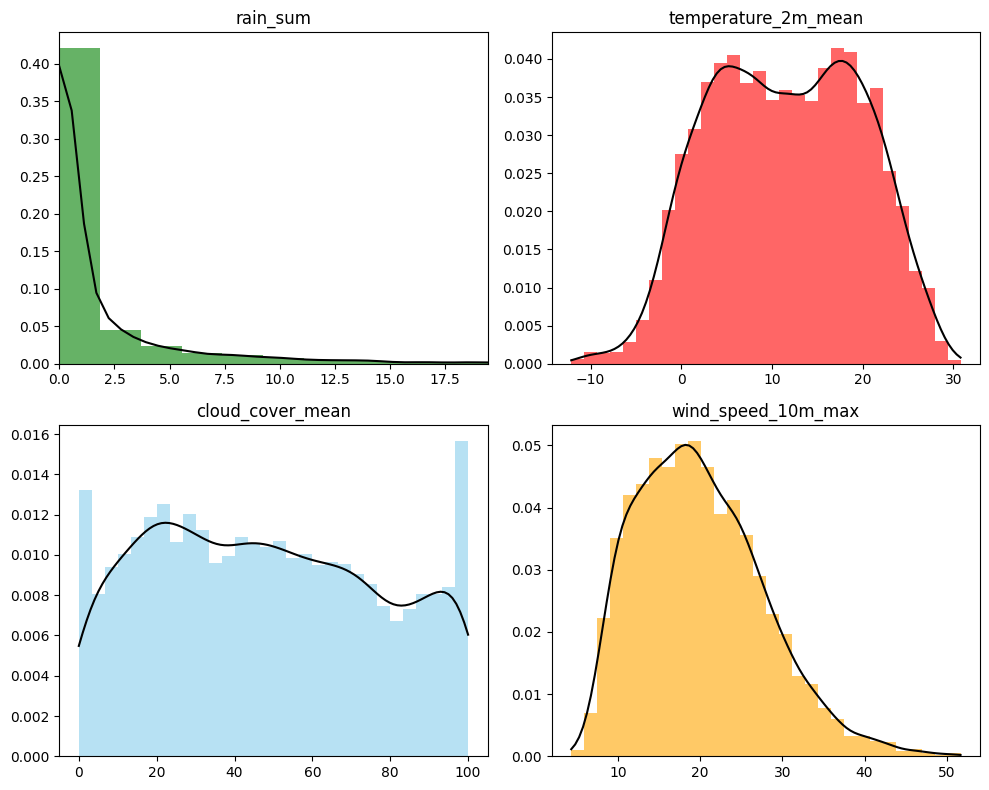

In [27]:
# Define the variables and colors for the subplots
variables = [
    'rain_sum',
    'temperature_2m_mean',
    'cloud_cover_mean',
    'wind_speed_10m_max'
]
colors = ["green", "red", "skyblue", "orange"]

# Create the subplots using a loop
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, var in enumerate(variables):
    column = daily_dataframe[var]
    ax = axs[i // 2, i % 2]
    ax.hist(column, bins=30, color=colors[i], alpha=0.6, density=True)
    ax.set_title(f'{var}')
    
    # Add KDE plot
    density = gaussian_kde(column)
    x_vals = np.linspace(min(column), max(column), 100)
    ax.plot(x_vals, density(x_vals), color='black')
    
    # Adjust x-axis for rain_sum
    if var == 'rain_sum':
        ax.set_xlim([0, np.percentile(column, 99)])

plt.tight_layout()
plt.show()



### Should We Clean the Cloud Data Extremes?

The Cloud Cover Mean (Bottom Left) histogram and KDE plot show slight peaks at both ends of the spectrum (0% and 100%). Before deciding to clean these extremes, consider the following:

* Nature of Extremes: Cloud cover extremes (0% and 100%) could represent clear days and completely overcast days, which are legitimate weather conditions. Removing these could lead to loss of iportant data.
* Data Integrity: Check if the extreme values are consistent with other weather parameters (e.g., clear skies with high sun exposure or overcast conditions with high humidity).
* Impact on Analysis: Determine how these extremes affect your analysis and model performance.


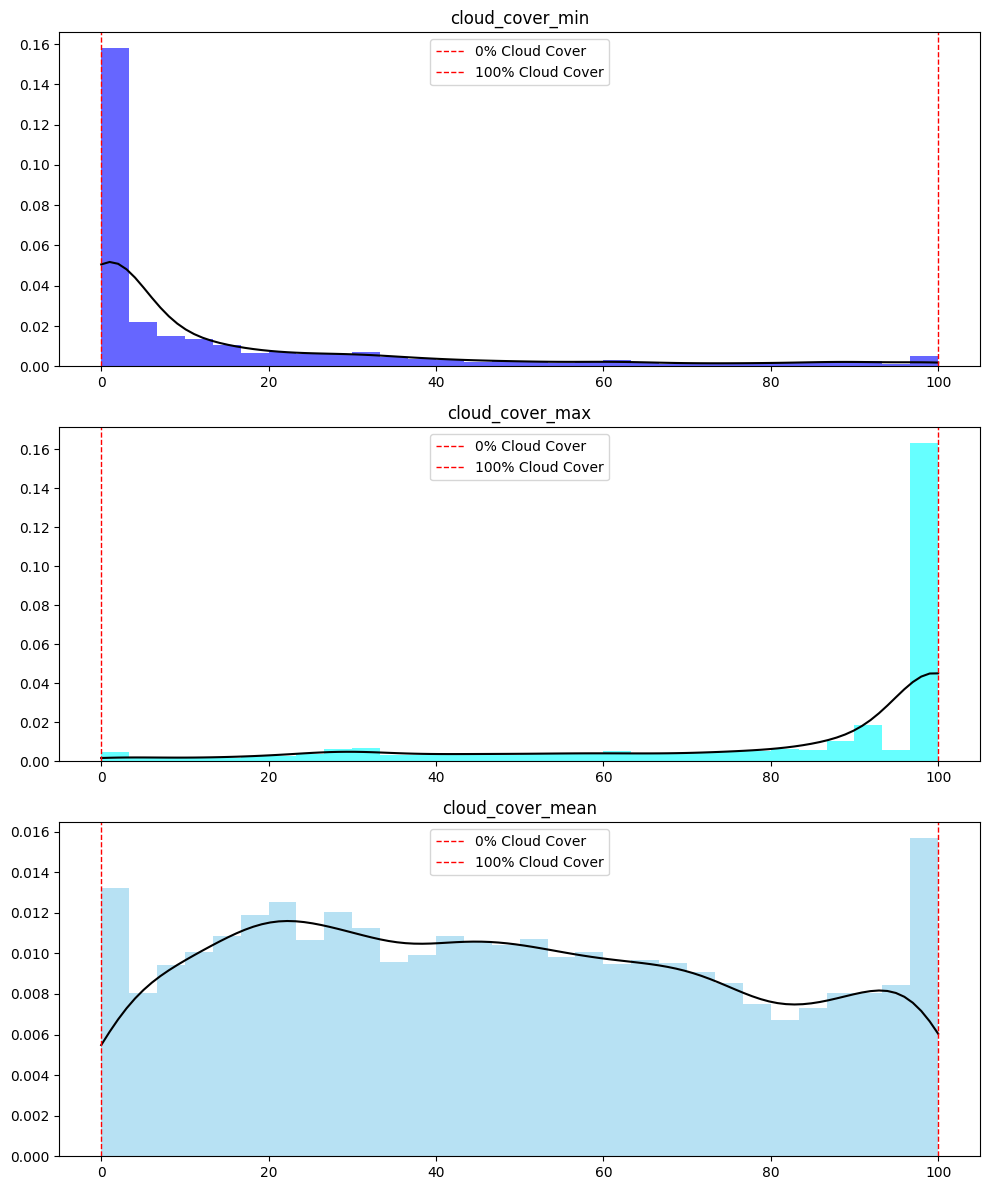

In [28]:
cloud_variables = ['cloud_cover_min', 'cloud_cover_max', 'cloud_cover_mean']
colors = ["blue", "cyan", "skyblue"]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
for i, var in enumerate(cloud_variables):
    column = daily_dataframe[var]
    ax = axs[i]
    ax.hist(column, bins=30, color=colors[i], alpha=0.6, density=True)
    ax.set_title(f'{var}')
    
    # Add KDE plot
    density = gaussian_kde(column)
    x_vals = np.linspace(min(column), max(column), 100)
    ax.plot(x_vals, density(x_vals), color='black')
    
    # Highlighting the extremes (0% and 100%)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, label='0% Cloud Cover')
    ax.axvline(x=100, color='red', linestyle='--', linewidth=1, label='100% Cloud Cover')
    ax.legend()

plt.tight_layout()
plt.show()

### Analysis Cloud Data

**Cloud Cover Min:**
* Distribution: The majority of the minimum cloud cover values are clustered around 0%, indicating many days start with clear skies.
* Extremes: A small number of instances are at 100%, suggesting completely overcast starts on some days.

**Cloud Cover Max:**
* Distribution: A significant peak at 100% cloud cover indicates many days have periods of full cloud cover.
* Extremes: Very few instances of minimum cloud cover, reinforcing frequent overcast conditions.

**Cloud Cover Mean:**
* Distribution: The mean cloud cover is fairly uniform, with slight peaks around 0% and 100%.
* Extremes: Peaks at both ends suggest regular occurrences of completely clear or overcast days, with a generally varied cloud cover on average days.

**Conclusion:**
* Valid Extremes: The peaks at 0% and 100% in both the minimum and maximum cloud cover are consistent with typical weather patterns.
* Action: No immediate cleaning is necessary, but further context-specific validation can ensure these extremes are not artifacts.

### Classification Model with Random Forest Method

The Random Forest model is an ensemble learning technique used for classification and regression. It builds multiple decision trees during training, each on a different random subset of the data and features. The final prediction is based on the majority vote for classification or the average for regression. This method reduces overfitting and improves accuracy by combining the outputs of many trees. It handles large datasets and many features well, and provides insights into feature importance. However, it can be computationally intensive and less interpretable compared to a single decision tree. Despite this, Random Forests are popular for their robustness and high performance across various tasks.

**Feature and Target Selection**
The target variable is precipitation_<lambda>, representing whether precipitation occurred. Features include all other weather variables, excluding rain_sum and snowfall_sum to prevent data leakage.

**Data Splitting**
The dataset is split into training (80%) and testing (20%) sets to evaluate the model's performance on unseen data.

**Model Training**
A RandomForestClassifier is chosen for its robustness and ability to handle various data types. It consists of 100 decision trees, trained on the training data.

**Predictions**
The trained model is used to predict the target variable on the test set, allowing for performance evaluation.

**Model Evaluation**
The model's performance is assessed using classification metrics (precision, recall, F1-score) and a confusion matrix, providing insights into its accuracy and error rates.

**Confusion Matrix Visualization**
A heatmap of the confusion matrix visually represents the model's performance, showing true positives, true negatives, false positives, and false negatives.

**Feature Importance Visualization**
The importance of each feature in the prediction model is visualized, helping to understand which variables most influence the model's decisions.

**Tree Visualization**
The first decision tree in the Random Forest is visualized to provide insights into the model's decision-making process.

**Summary**
The script starts by preparing the dataset, selecting relevant features, and identifying the target variable for precipitation prediction. The data is split into training and testing sets to build and evaluate the model's performance accurately. A Random Forest classifier is chosen for its capability to handle diverse data types and capture complex interactions.

After training the model, predictions are made on the test set, followed by a thorough evaluation using classification metrics and a confusion matrix. The confusion matrix heatmap provides a visual representation of the model's accuracy and errors.

Feature importance is then visualized to highlight which weather variables most influence precipitation predictions. Finally, the script visualizes the first decision tree in the Random Forest, offering a glimpse into the model's decision-making process.

This comprehensive approach ensures a robust evaluation and understanding of the model, helping to identify key factors driving precipitation and providing a foundation for further improvements and applications.

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       484
           1       0.77      0.79      0.78       542

    accuracy                           0.76      1026
   macro avg       0.76      0.76      0.76      1026
weighted avg       0.76      0.76      0.76      1026

[[353 131]
 [113 429]]


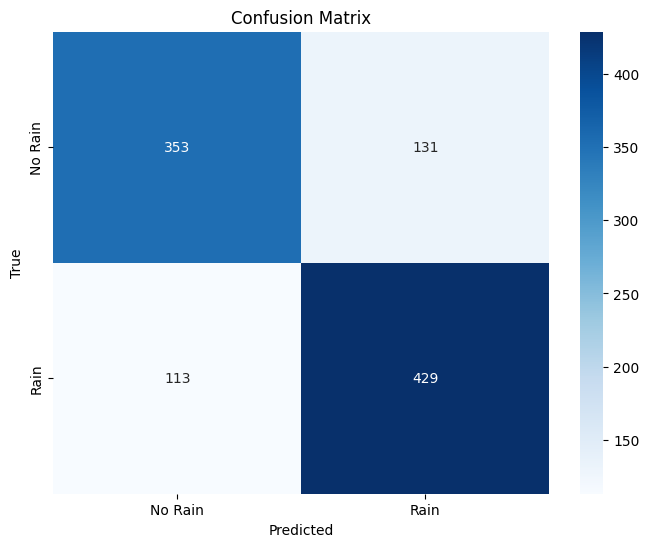

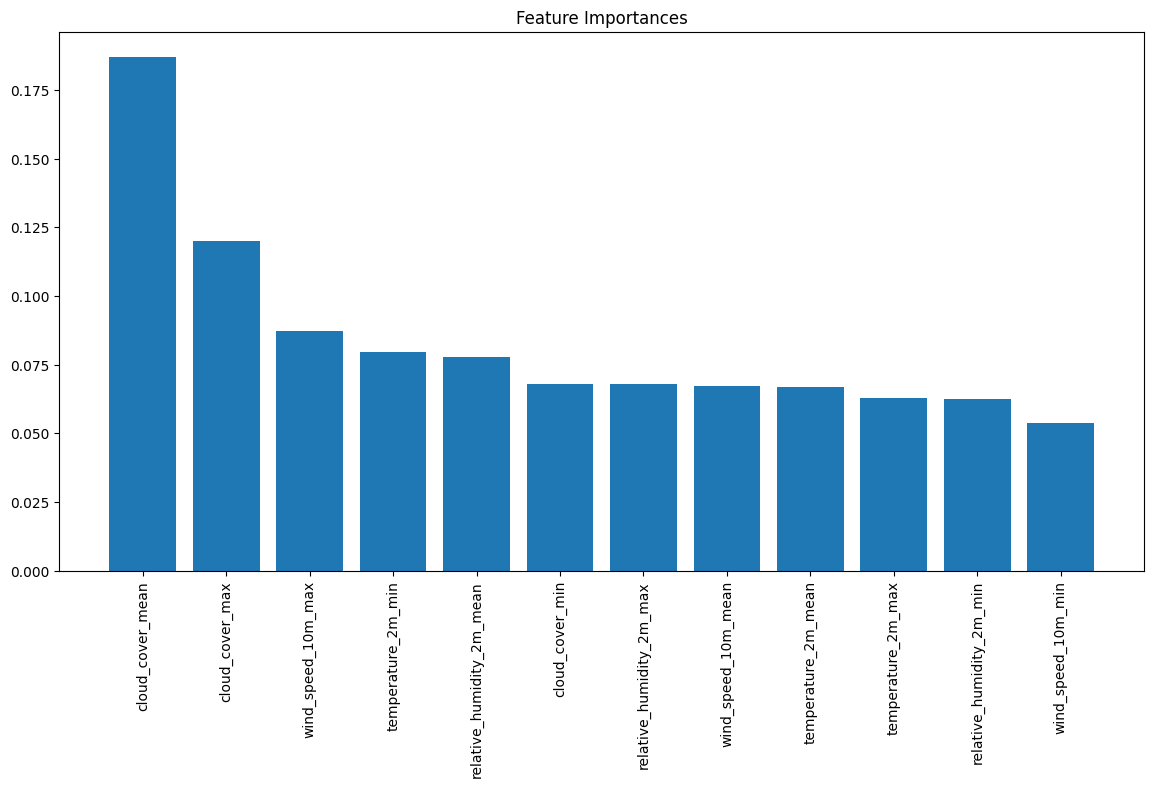

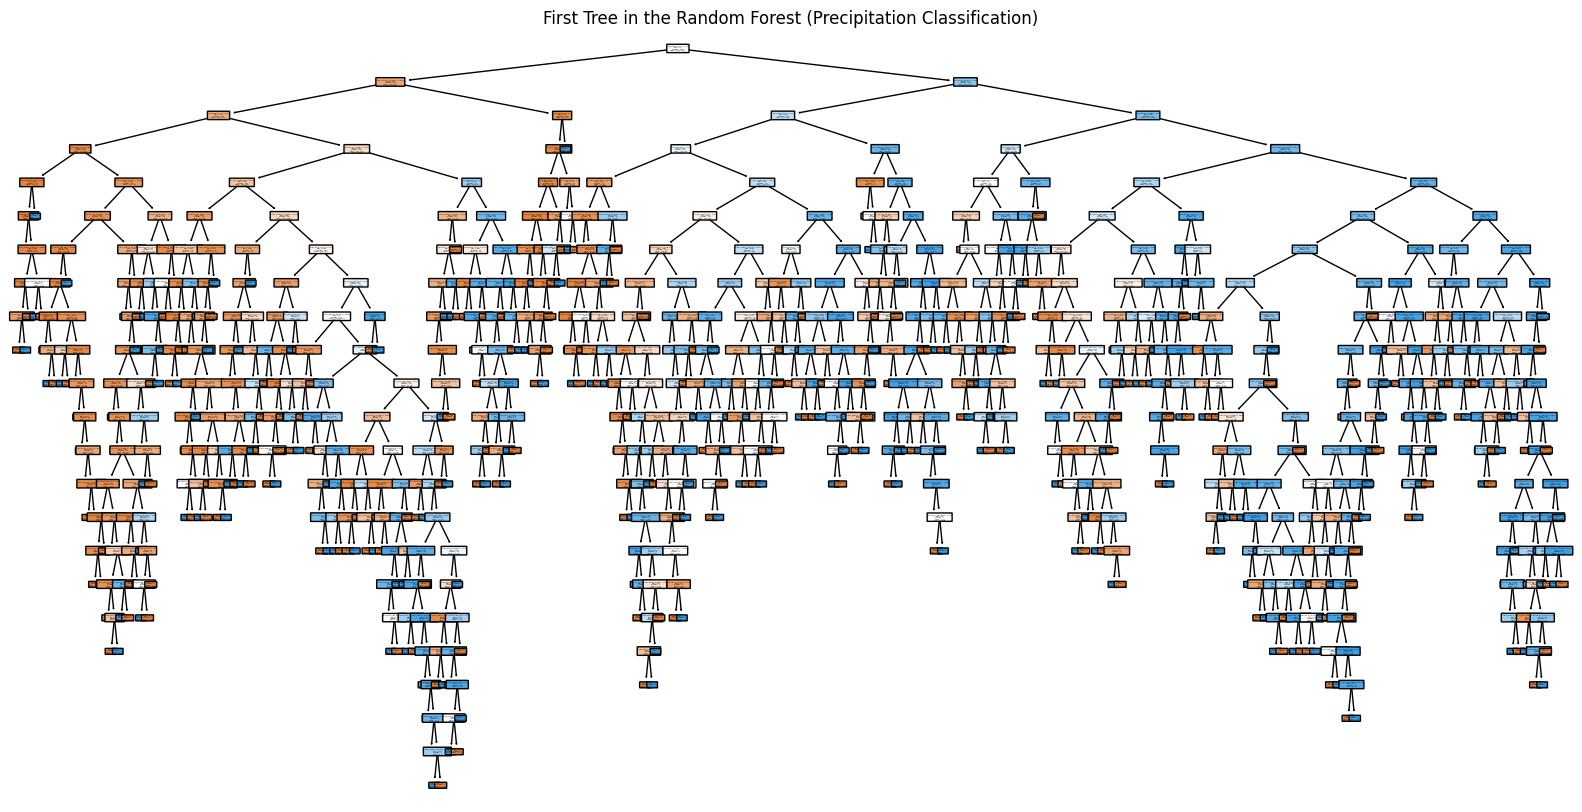

In [29]:
# Define features and target variable
target = 'precipitation_<lambda>'
features = [col for col in daily_dataframe.columns if col != target and col not in ['rain_sum', 'snowfall_sum']]
X = daily_dataframe[features]
y = daily_dataframe[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance visualization
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Visualize the first tree in the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=features, class_names=['No Rain', 'Rain'], filled=True, rounded=True)
plt.title("First Tree in the Random Forest (Precipitation Classification)")
plt.show()

The Random Forest classification model developed in this project aims to predict precipitation based on a comprehensive set of weather features.

* Data Splitting: The dataset was split into 80% for training and 20% for testing.
* Model Performance: The model achieved an overall accuracy of 76%.
* Precision and Recall: Balanced precision and recall for predicting both rain and no rain, with F1-scores of 0.74 for no rain and 0.78 for rain.
* Confusion Matrix: Correctly predicts 353 non-rain days and 429 rain days, with some misclassifications.


**Confusion Matrix Description**

The confusion matrix visualizes the performance of the Random Forest classifier for predicting precipitation. Here's a detailed explanation:

* True Negatives (Top Left): 353 instances where the model correctly predicted 'No Rain'.
* False Positives (Top Right): 131 instances where the model incorrectly predicted 'Rain' when it was actually 'No Rain'.
* False Negatives (Bottom Left): 113 instances where the model incorrectly predicted 'No Rain' when it was actually 'Rain'.
* True Positives (Bottom Right): 429 instances where the model correctly predicted 'Rain'.

The color intensity in the heatmap represents the count of predictions in each category, with darker colors indicating higher values. The matrix shows that the model has a balanced performance, with a good number of correct predictions in both categories but also some misclassifications.

**Feature Importance Visualization Description**

The bar chart displays the importance of various features used by the Random Forest model to predict precipitation. The features are ranked based on their importance, with higher bars indicating greater influence on the model's predictions.

Top Features:
* Cloud Cover Mean: The most important feature, indicating that the average cloud cover has the highest impact on predicting precipitation.
* Cloud Cover Max: Also significantly important, showing that the maximum cloud cover is a key factor.
* Wind Speed 10m Max: Contributes to the model, suggesting that higher wind speeds are relevant to precipitation.

Other Notable Features:
* Temperature 2m Min: Minimum temperature influences the prediction.
* Relative Humidity Mean and Max: Both are important, indicating that humidity levels are crucial for precipitation forecasts.

This visualization helps in understanding which weather variables most influence the model's decision-making process for predicting precipitation.

**Description of the Decision Tree Visualization**

The visualization shows one of the decision trees from the Random Forest model used for precipitation classification. Here's a detailed breakdown:

* Tree Structure: Each node represents a decision based on a feature and a threshold value.
* Splits: The tree splits data at each node to maximize the separation between classes ('Rain' and 'No Rain').
* Leaf Nodes: Terminal nodes (leaves) indicate the final class prediction for the given path of decisions.
* Color Coding: Nodes are color-coded based on the majority class they represent, with shades indicating the purity of the node (darker for purer).

Key Points
* Root Node: The top node is the root, where the first split occurs based on the most important feature.
* Depth: The tree's depth and branching indicate the complexity and how finely the model splits the data.
* Class Distribution: The proportion of 'Rain' vs. 'No Rain' in each node is visually represented.

This detailed visualization helps understand how individual decisions contribute to the overall classification, providing transparency in the model's decision-making process.

### Classification Model with Logistic Regression

Logistic Regression is a statistical method for binary classification that predicts the probability of an outcome, coded as 0 or 1. It models the relationship between the features and the binary outcome using the logistic function, which outputs probabilities between 0 and 1. The model coefficients are estimated to maximize the likelihood of observing the given data. Logistic Regression is simple, interpretable, and effective for small datasets with fewer features. It assumes a linear relationship between the log-odds of the outcome and the features. While it has some limitations, such as sensitivity to feature correlation, it remains a fundamental tool for binary classification due to its efficiency and ease of use.

**Feature and Target Selection**
The target variable is precipitation_<lambda>, representing whether precipitation occurred. Features include all other weather variables, excluding rain_sum and snowfall_sum to prevent data leakage.

**Data Splitting**
The dataset is split into training (80%) and testing (20%) sets to evaluate the model's performance on unseen data.

**Model Training**
A LogisticRegression classifier is chosen for its simplicity and interpretability. The model is trained on the training data with a maximum of 1000 iterations.

**Predictions**
The trained model is used to predict the target variable on the test set, allowing for performance evaluation.

**Model Evaluation**
The model's performance is assessed using classification metrics (precision, recall, F1-score) and a confusion matrix, providing insights into its accuracy and error rates.

**Confusion Matrix Visualization**
A heatmap of the confusion matrix visually represents the model's performance, showing true positives, true negatives, false positives, and false negatives.

**Feature Importance Visualization**
The importance of each feature in the prediction model is visualized based on the model coefficients, helping to understand which variables most influence the model's decisions.

**Summary**
The script starts by preparing the dataset, selecting relevant features, and identifying the target variable for precipitation prediction. The data is split into training and testing sets to build and evaluate the model's performance accurately. A LogisticRegression classifier is chosen for its simplicity and ability to provide a clear understanding of feature influences through its coefficients.

After training the model, predictions are made on the test set, followed by a thorough evaluation using classification metrics and a confusion matrix. The confusion matrix heatmap provides a visual representation of the model's accuracy and errors.

Feature importance is then visualized based on the model coefficients to highlight which weather variables most influence precipitation predictions.

This approach ensures a robust evaluation and understanding of the model, helping to identify key factors driving precipitation and providing a foundation for further improvements and applications.

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       484
           1       0.75      0.80      0.77       542

    accuracy                           0.75      1026
   macro avg       0.75      0.75      0.75      1026
weighted avg       0.75      0.75      0.75      1026

[[336 148]
 [108 434]]


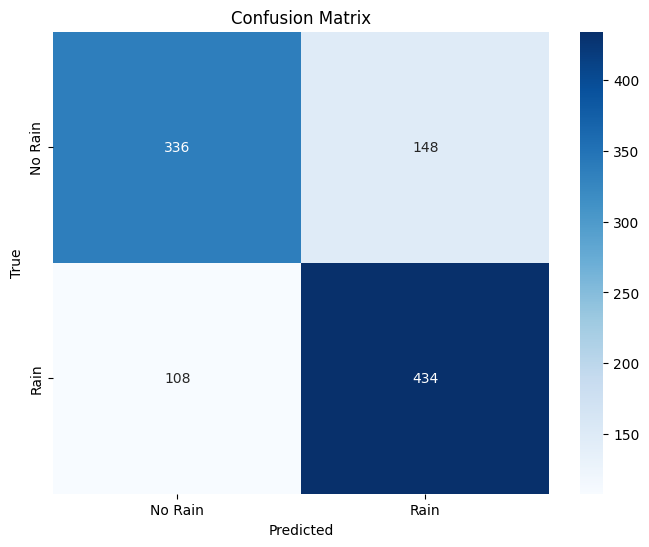

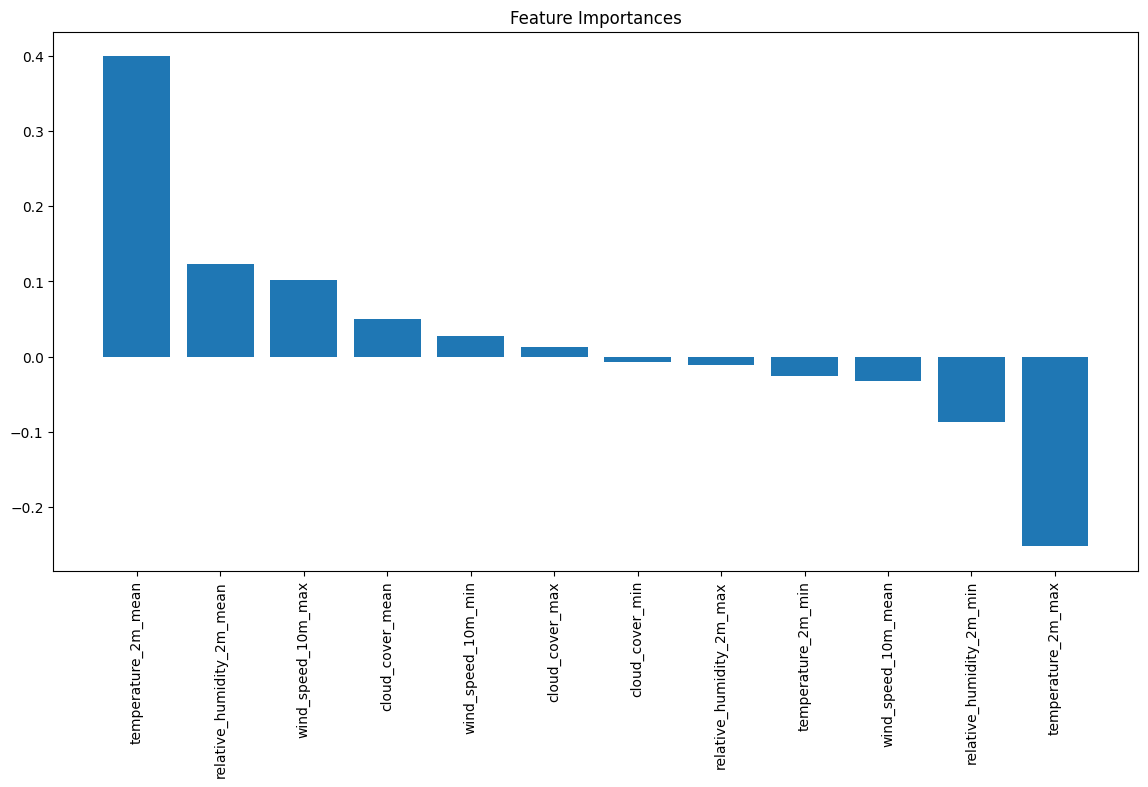

In [30]:
# Define features and target variable
target = 'precipitation_<lambda>'
features = [col for col in daily_dataframe.columns if col != target and col not in ['rain_sum', 'snowfall_sum']]
X = daily_dataframe[features]
y = daily_dataframe[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression classifier
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance visualization for logistic regression (coefficients)
coefficients = model.coef_[0]
indices = np.argsort(coefficients)[::-1]

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), coefficients[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

The Logistic Regression classification model developed in this project aims to predict precipitation based on a comprehensive set of weather features.

Data Splitting: The dataset was split into 80% for training and 20% for testing.
Model Performance: The model achieved an overall accuracy of 75%.
Precision and Recall: Balanced precision and recall for predicting both rain and no rain, with F1-scores of 0.72 for no rain and 0.77 for rain.
Confusion Matrix: Correctly predicts 336 non-rain days and 434 rain days, with some misclassifications.

The Logistic Regression classification model developed in this project aims to predict precipitation based on a comprehensive set of weather features.

* Data Splitting: The dataset was split into 80% for training and 20% for testing.
* Model Performance: The model achieved an overall accuracy of 75%.
* Precision and Recall: Balanced precision and recall for predicting both rain and no rain, with F1-scores of 0.72 for no rain and 0.77 for rain.
* Confusion Matrix: Correctly predicts 336 non-rain days and 434 rain days, with some misclassifications.


**Confusion Matrix Description**
The confusion matrix visualizes the performance of the Logistic Regression classifier for predicting precipitation. Here's a detailed explanation:

* True Negatives (Top Left): 336 instances where the model correctly predicted 'No Rain'.
* False Positives (Top Right): 148 instances where the model incorrectly predicted 'Rain' when it was actually 'No Rain'.
* False Negatives (Bottom Left): 108 instances where the model incorrectly predicted 'No Rain' when it was actually 'Rain'.
* True Positives (Bottom Right): 434 instances where the model correctly predicted 'Rain'.

The color intensity in the heatmap represents the count of predictions in each category, with darker colors indicating higher values. The matrix shows that the model has a balanced performance, with a good number of correct predictions in both categories but also some misclassifications.

**Feature Importance Visualization Description**
The bar chart displays the importance of various features used by the Logistic Regression model to predict precipitation. The features are ranked based on their importance, with higher bars indicating greater influence on the model's predictions.

Top features:
* Temperature 2m Mean: The most important feature, indicating that the average temperature has the highest impact on predicting precipitation.
* Relative Humidity 2m Mean: Also significantly important, showing that average relative humidity is a key factor.
* Wind Speed 10m Max: Contributes to the model, suggesting that higher wind speeds are relevant to precipitation.

Other Notable Features:
* Cloud Cover Mean: Average cloud cover influences the prediction.
* Wind Speed 10m Min: Minimum wind speed also has an impact.
* Temperature 2m Max: Higher maximum temperatures have a negative weight in the model.

This visualization helps in understanding which weather variables most influence the model's decision-making process for predicting precipitation.

### Comparison of Random Forest and Logistic Regression Models for Precipitation Prediction

When choosing a model for predicting precipitation, it's essential to compare the theoretical foundations and practical applications of different approaches. This comparison focuses on two widely used models: Random Forest and Logistic Regression, highlighting their strengths, weaknesses, and suitability for various data patterns and requirements.

| **Aspect**                         | **Random Forest**                             | **Logistic Regression**                       |
|------------------------------------|------------------------------------------------|-----------------------------------------------|
| **Type**                           | Ensemble Learning, Bagging                    | Linear Model, Binary Classification           |
| **Complexity**                     | High, uses multiple decision trees            | Low, simple linear relationships              |
| **Interpretability**               | Low, due to ensemble nature                   | High, coefficients directly interpretable     |
| **Handling of Non-Linearity**      | Excellent, captures complex relationships     | Poor, only linear boundaries                  |
| **Overfitting**                    | Controlled by averaging multiple trees        | Less prone, may require regularization        |
| **Feature Importance**             | Based on impurity reduction                   | Based on model coefficients                   |
| **Computational Cost**             | High, due to training multiple trees          | Low, efficient for large datasets             |
| **Usage**                          | Suitable for complex datasets with non-linear relationships | Suitable for simpler datasets with linear separability |

* Random Forest is ideal for capturing complex, non-linear relationships and providing high accuracy at the cost of interpretability and computational resources.
* Logistic Regression offers simplicity and interpretability, performing well on linearly separable data with low computational cost.

| **Aspect**           | **Random Forest**                                                                 | **Logistic Regression**                                           |
|----------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------------|
| **Strengths**        | * Better overall accuracy and slightly higher precision and recall.               | * Simpler and more interpretable due to its linear nature.        |
|                      | * Captures complex, non-linear relationships in the data.                        | * Easier to implement and computationally efficient.              |
|                      | * Provides a robust model for diverse weather patterns.                          | * Good performance with slightly better recall for rain predictions.|
| **Weaknesses**       | * Less interpretable due to its complexity and use of multiple decision trees.    | * Slightly lower overall accuracy compared to Random Forest.      |
|                      | * Computationally more intensive and harder to implement in real-time applications.| * May not capture complex relationships as effectively.            |


**Comparison of our Model Results**

The Random Forest model achieves an accuracy of 76%, slightly higher than the Logistic Regression model's 75%. For predicting 'No Rain', both models have a precision of 76%, but Random Forest shows better recall (73% vs. 69%), resulting in a higher F1-score (0.74 vs. 0.72). For 'Rain' predictions, Logistic Regression exhibits better recall (80% vs. 79%), but Random Forest has higher precision (77% vs. 75%), leading to a marginally better F1-score (0.78 vs. 0.77). The confusion matrix shows that Random Forest correctly identifies more true negatives (353 vs. 336) and has fewer false positives (131 vs. 148), whereas Logistic Regression has slightly more true positives (434 vs. 429) and fewer false negatives (108 vs. 113). Overall, Random Forest is better at capturing complex patterns, while Logistic Regression offers simplicity and ease of interpretation.

| **Metric**                         | **Random Forest Model**                             | **Logistic Regression Model**                       |
|------------------------------------|-----------------------------------------------------|-----------------------------------------------------|
| **Accuracy**                       | 76%                                                 | 75%                                                 |
| **No Rain** - Precision            | 76%                                                 | 76%                                                 |
| **No Rain** - Recall               | 73%                                                 | 69%                                                 |
| **No Rain** - F1-Score             | 0.74                                                | 0.72                                                |
| **Rain** - Precision               | 77%                                                 | 75%                                                 |
| **Rain** - Recall                  | 79%                                                 | 80%                                                 |
| **Rain** - F1-Score                | 0.78                                                | 0.77                                                |
| **True Negatives (No Rain)**       | 353                                                 | 336                                                 |
| **False Positives (No Rain)**      | 131                                                 | 148                                                 |
| **False Negatives (Rain)**         | 113                                                 | 108                                                 |
| **True Positives (Rain)**          | 429                                                 | 434                                                 |


**Conclusion: Choosing Between Random Forest and Logistic Regression Models**
Based on the comparative analysis, the Random Forest model is the preferable choice for predicting precipitation. Here are the arguments supporting this conclusion:

1. Higher Overall Accuracy:
Random Forest has a slightly better overall accuracy (76%) compared to Logistic Regression (75%), indicating better performance in correctly predicting precipitation events.

2. Better Handling of Complex Relationships:
Random Forest captures complex, non-linear interactions between features, making it more suitable for datasets with intricate patterns, such as weather data.

3. Superior Performance in Key Metrics:
* For 'No Rain' predictions, Random Forest shows better recall (73% vs. 69%) and F1-score (0.74 vs. 0.72).
* For 'Rain' predictions, Random Forest exhibits higher precision (77% vs. 75%) and F1-score (0.78 vs. 0.77), despite Logistic Regression having slightly better recall (80% vs. 79%).

4. Robust Model for Diverse Conditions:
The ensemble nature of Random Forest ensures robustness and reliability across various weather conditions, providing a comprehensive model for precipitation prediction.

5. Reduced False Positives:
Random Forest has fewer false positives (131 vs. 148), which is crucial for applications where predicting rain incorrectly could lead to unnecessary actions or alerts.

**Summary**
While Logistic Regression offers simplicity and interpretability, its slightly lower accuracy and inability to capture complex relationships make Random Forest the better choice for this application. Random Forest's higher accuracy, better handling of non-linear interactions, and robustness make it the preferred model for predicting precipitation in weather data.







